# Question 3

## (a)

K-fold cross validation is implemented by:

1) Dividing dataset into k groups of len n/k.

2) Save the first fold as the validation set. 

3) Compute the MSE for all other folds, leaving out df[k], the validation set

4) Calculate the mean of all MSEs to get an estimate of the k-fold CV.

## (b)

i. Validation Set

K-fold CV has less variance as it's estimate is generated over k folds. Validation sets are a simple and lightweight computation. It is only trained once but it leaves room for high variance as a training set is not being utilized. This affects small datasets. The bias is also strong if the validation set does not properly represent the overall dataset.

ii. LOOCV

K-fold CV has better computational performance than LOOCV as n increases. The bias-variance trade off also helps propogate off variance and introducing bias as the validation set is left out. LOOCV works best on small datasets as it is more flexible and can be more precise. 

# Question 6

In [6]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

h2o_df = h2o.import_file('Default.csv')
h2o_df['default'] = (h2o_df['default'] == 'Yes').ifelse(1, 0)
model = H2OGeneralizedLinearEstimator(family='gaussian')
model.train(y='default', x=['income', 'balance'], training_frame=h2o_df)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 mins 22 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_woody_xosda2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.961 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\woody\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1728409804460_2


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 1.256E-4 )  2                             2                              1                       py_1_sid_8e2b

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.028208219041171385
RMSE: 0.16795302629357825
MAE: 0.08028429631774625
RMSLE: 0.11881966634763362
Mean Residual Deviance: 0.028208219041171385
R^2: 0.12372642505426545
Null degrees of freedom: 9999
Residual degrees of freedom: 9997
Null deviance: 321.9110999999998
Residual deviance: 282.08219041171384
AIC: -7294.6482173289905

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective            training_rmse        training_deviance     training_mae         training_r2
--  -------------------  ----------  ------------  -------------------------  -------------------  -------------------  --------------------  -------------------  -------------------
    2024-10-08 13:55:44  0.000 sec   0             321.9110999999998          0.03219110999999998
    2024-10-08 13:55:44  0.074 sec   1                                                             0.16795302629357825  0.028208219041171385  0.08028429631774625  0.12372642505426545

Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
balance     0.0635996              1                    0.913973
income      0.00598623             0.0941237            0.0860266

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

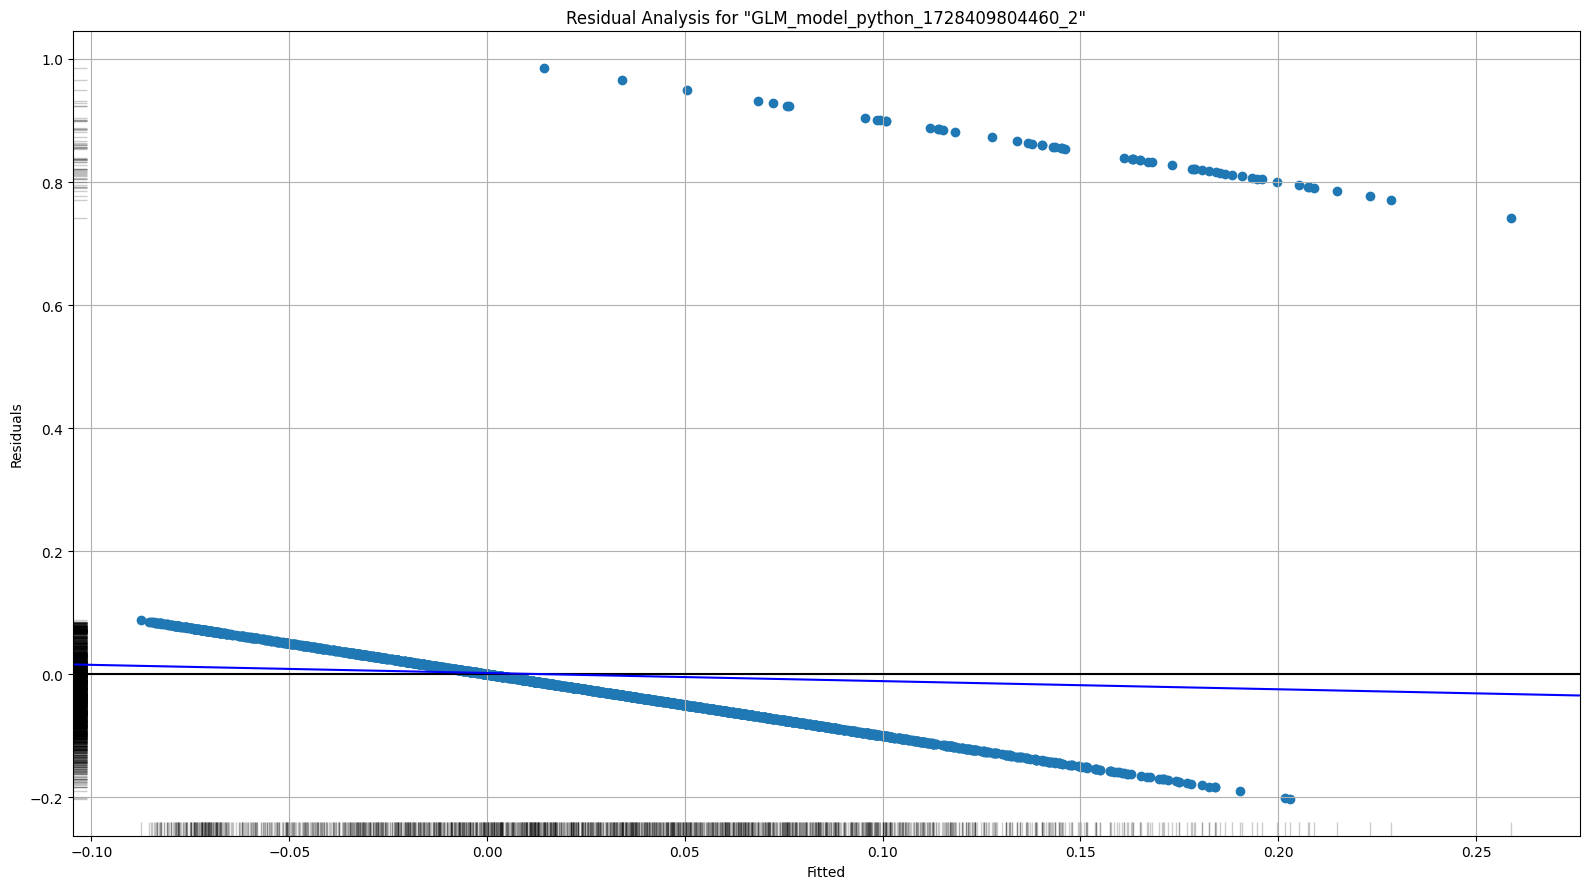

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

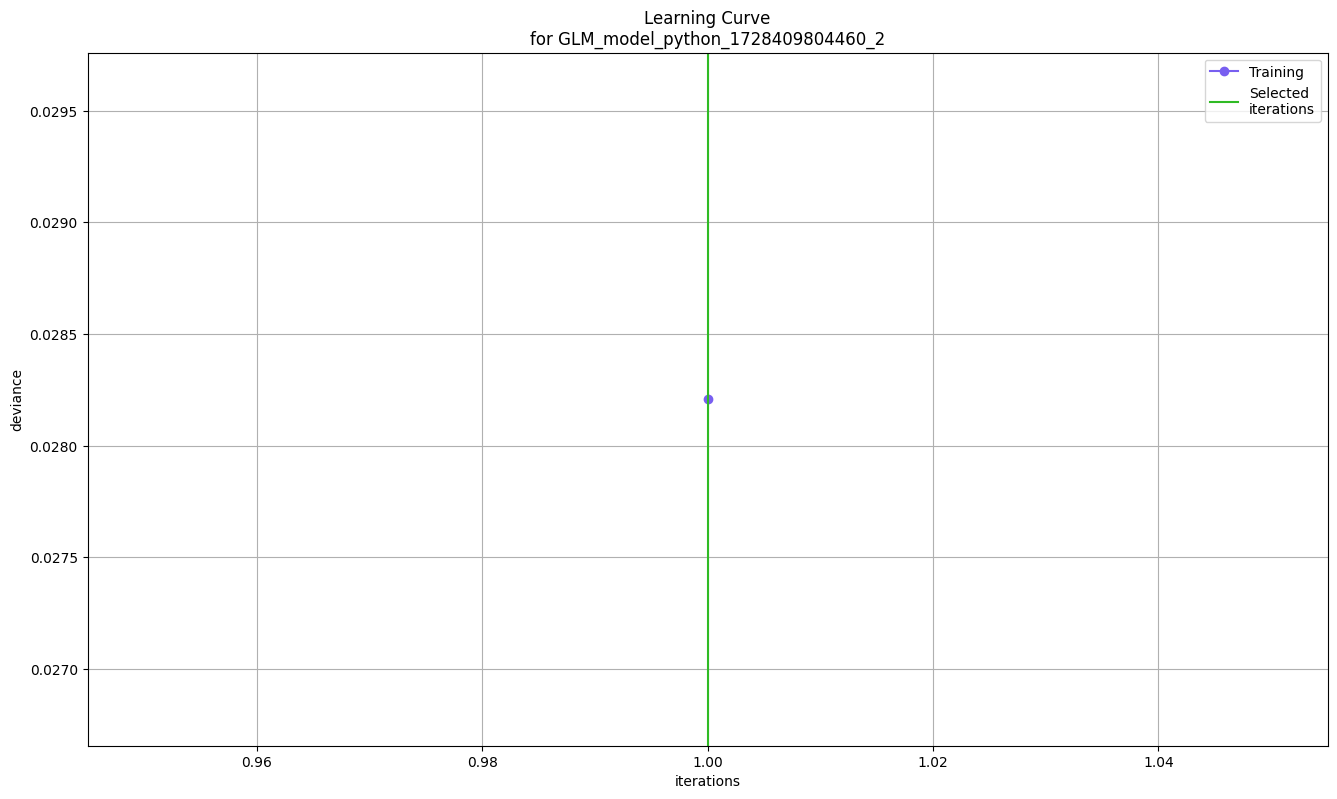

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

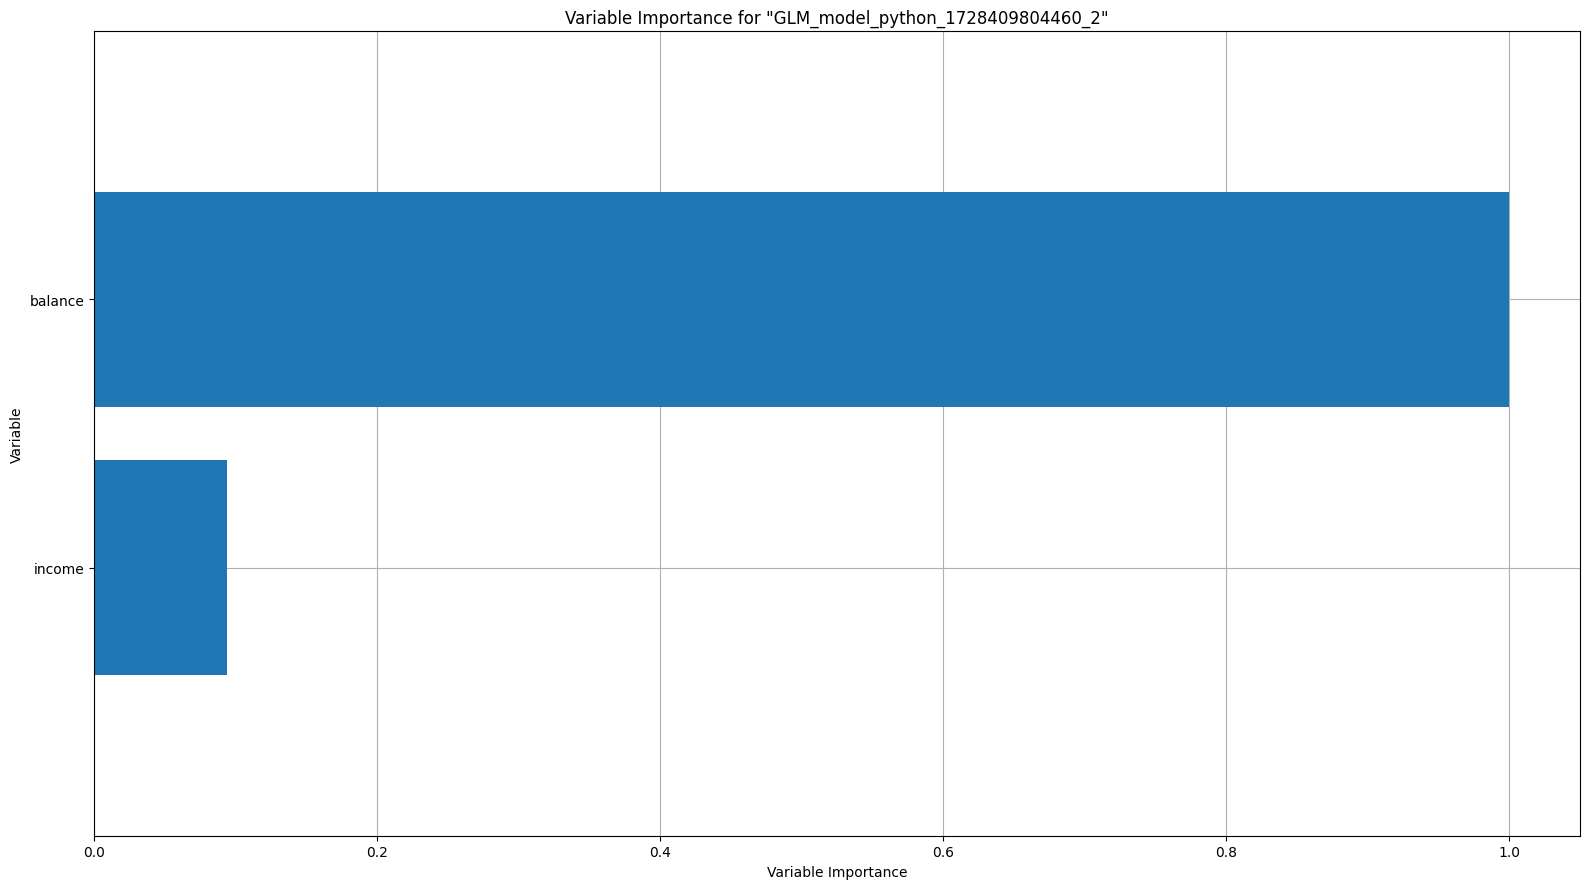

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

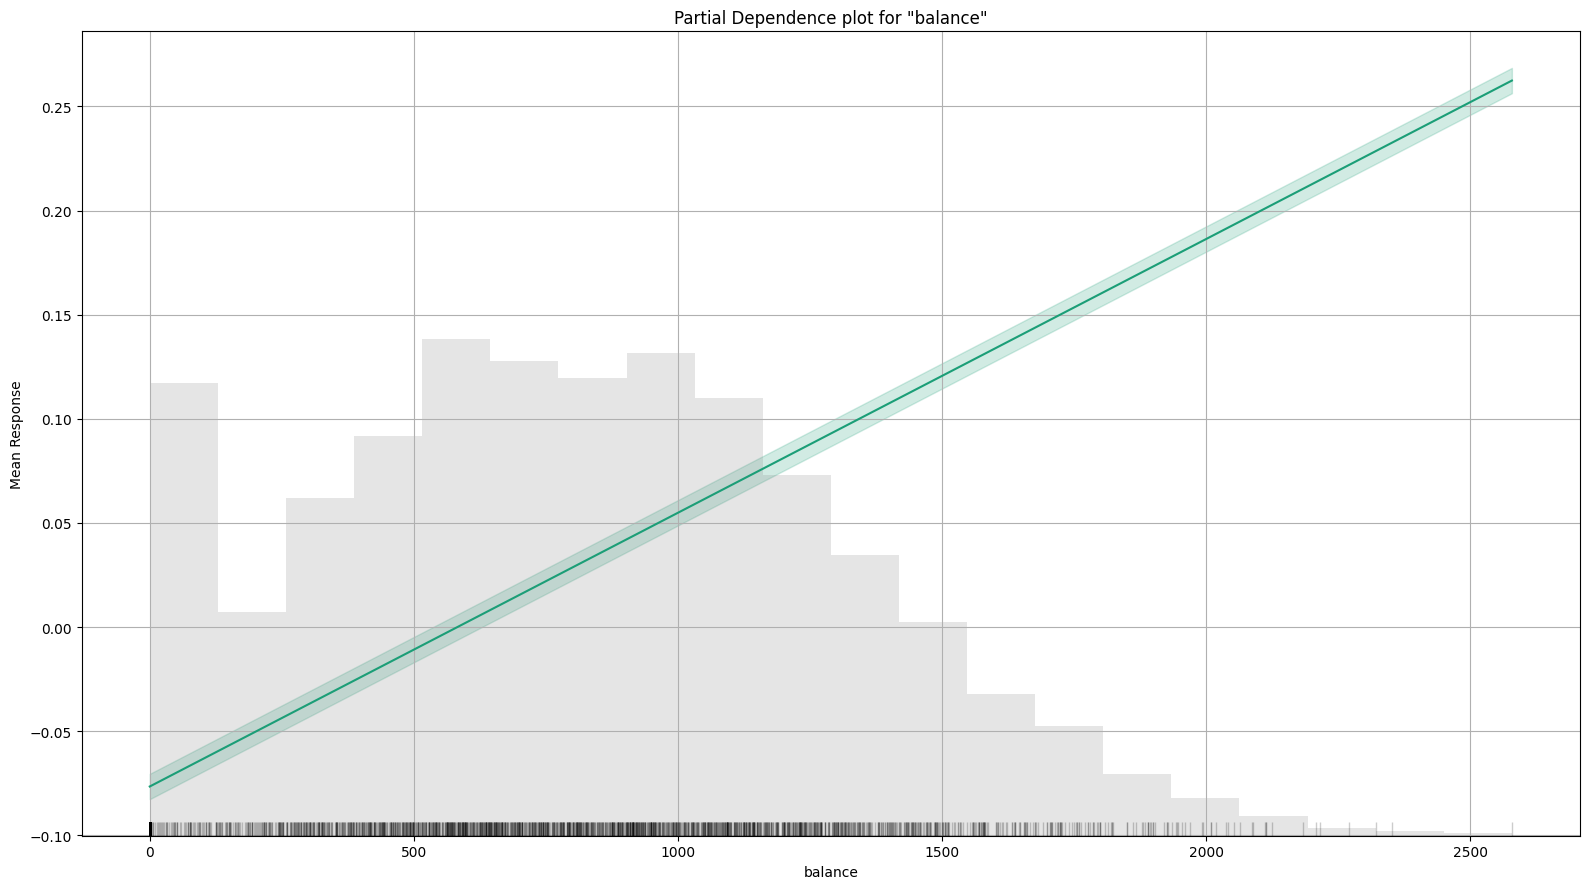

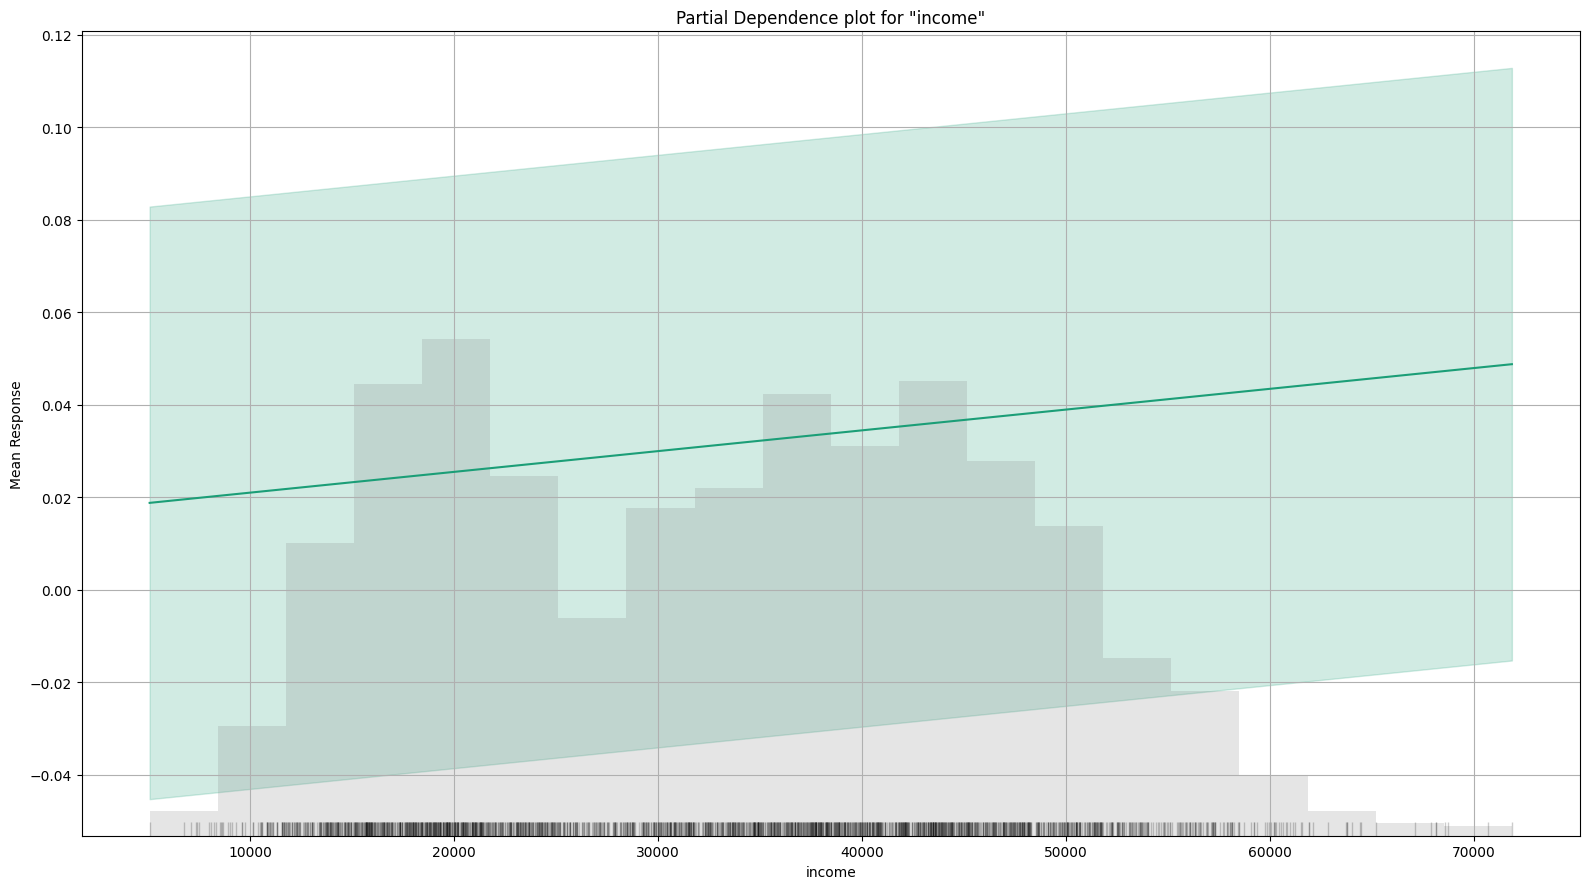

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

Exception ignored in: <function ExprNode.__del__ at 0x000002981F9BC720>
Traceback (most recent call last):
  File "c:\Users\woody\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\expr.py", line 204, in __del__
    ExprNode.rapids("(rm {})".format(self._cache._id))
  File "c:\Users\woody\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\expr.py", line 258, in rapids
    return h2o.api("POST /99/Rapids", data={"ast": expr, "session_id": h2o.connection().session_id})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\woody\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\h2o.py", line 123, in api
    return h2oconn.request(endpoint, data=data, json=json, filename=filename, save_to=save_to)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\woody\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\backend\connection.

In [ ]:
''' When h2o.explain() is provided a single model, we get the following global explanations:
Confusion Matrix (classification only)

Residual Analysis (regression only)

Variable Importance

Partial Dependence (PD) Plots

Individual Conditional Expectation (ICE) Plots
'''
train, test = h2o_df.split_frame(ratios=[0.8])
model.explain(test)

## (a)

In [ ]:
def boot_fn(data, index):
    return -1

# Question 7